# README for the simulator analysis

The main work is done in the model.py, but we want to re-use the code in this notebook as well:

In [2]:
%run model.py

b:\anaconda\envs\donkey\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


NOTE: Automatic training of the model is disabled when calling 'python model.py' because the code runs in the jupyter notebook.
      If you want to execute model.py as stand-alone then please un-comment the last line in model.py


## Input data and filtering
Let's have a look at our raw recorded data for training and validation:

In [14]:
# use and prefix to get to your clean sample data from the simulator (e.g. see simulator_training_data.zip)
train_json, adjusted, lengths = get_raw_data()  
print(train_json.shape)
print(lengths)
print(np.add.accumulate(lengths))

(23377,)
[5214, 7443, 4334, 6386]
[ 5214 12657 16991 23377]


Let's examine the input data a bit closer:

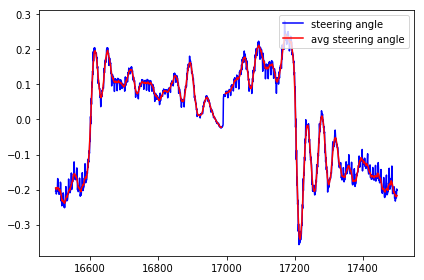

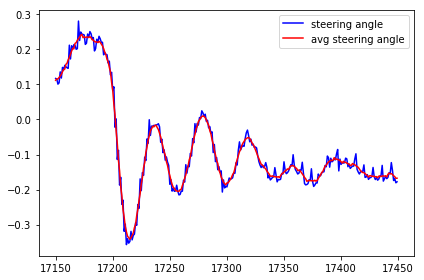

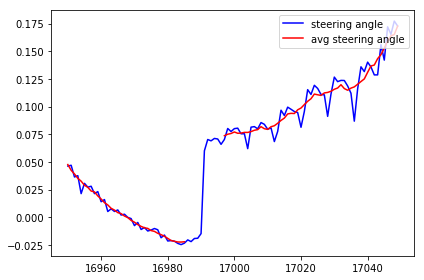

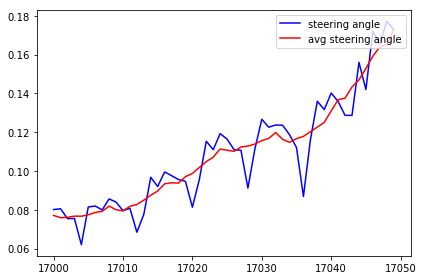

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook:
%matplotlib inline 


def plot_steering_angles(data, from_t = 0, to_t=None, filtered = False):
    to_t = int(to_t if to_t is not None else data.shape[0])

    t1 = np.arange(from_t, to_t, 1)
    values = [float(row[angle_pos]) for row in data[from_t:to_t]]
    adj_values = [float(row[angle_pos]) for row in adjusted[from_t:to_t]]
    plt.plot(t1, values, 'b-', label="steering angle")
    plt.plot(t1, adj_values, 'r-', label="avg steering angle")

    plt.legend(loc="upper right")

    plt.tight_layout()
    plt.show()
    
# plot_steering_angles(train_json,25000,27000)
plot_steering_angles(train_json,16500,17500)
plot_steering_angles(train_json,17150,17450)
plot_steering_angles(train_json,16950,17050)
plot_steering_angles(train_json,17000,17050)

(array([  48.,  192., 1093., 3010., 4520., 4685., 5066., 3541., 1024.,
         126.,   29.]),
 array([-0.42798311, -0.35035582, -0.27272853, -0.19510124, -0.11747395,
        -0.03984667,  0.03778062,  0.11540791,  0.1930352 ,  0.27066248,
         0.34828977,  0.42591706]),
 <a list of 11 Patch objects>)

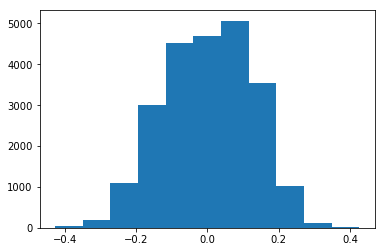

In [20]:
#remove NaNs:
bool_arr = np.array([not_nan_row(row) for row in adjusted])
adjusted = adjusted[bool_arr]

# print distributions of angles:
angles = get_all_angles(adjusted)
plt.hist(angles, bins=11)

(array([  5.,  15.,  60., 156., 195., 215., 231., 183.,  90.,  14.,   3.]),
 array([-0.39603689, -0.32538329, -0.25472969, -0.18407608, -0.11342248,
        -0.04276887,  0.02788473,  0.09853833,  0.16919194,  0.23984554,
         0.31049915,  0.38115275]),
 <a list of 11 Patch objects>)

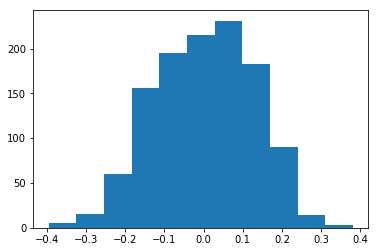

In [21]:
# sub-sampling: every N-th pictuyre is enough:
adjusted = sub_sample_data(adjusted, N=20)
angles = get_all_angles(adjusted)
plt.hist(angles, bins=11)

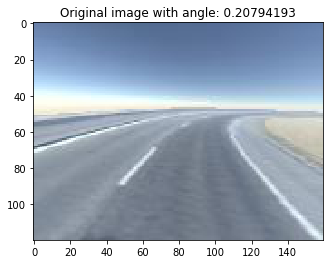

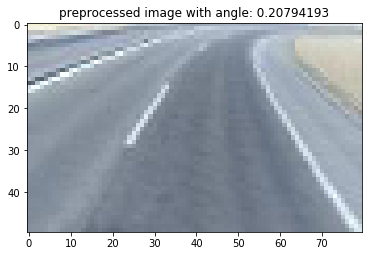

In [22]:
img_idx = 42

img = cv2.imread(adjusted[img_idx][image_pos])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original image with angle: " + str(adjusted[img_idx][angle_pos]))
plt.show()


img = get_image(img_idx, adjusted)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("preprocessed image with angle: " + str(adjusted[img_idx][angle_pos]))
plt.show()


## train and validation data:


In [24]:
train_csv, validation_csv = train_test_splity(adjusted, train_split = 0.8)

# get train input for model:
train_data = get_stacked_data(train_csv)
train_angles = get_all_angles(train_csv)
train_throttles = get_all_throttles(train_csv)

# get validation input for model:
validation_data = get_stacked_data(validation_csv)
validation_angles = get_all_angles(validation_csv)
validation_throttles = get_all_throttles(validation_csv)

print('train_data.shape: \t', train_data.shape)
print('train_angles.shape: \t', train_angles.shape)
print('train_throttles.shape: \t', train_throttles.shape)
print('validation_data.shape: \t', validation_data.shape)
print('validation_angles.shape:', validation_angles.shape)
print('validation_throttles.shape:', validation_throttles.shape)


b:\anaconda\envs\donkey\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


train_data.shape: 	 (933, 50, 80, 3)
train_angles.shape: 	 (933, 1)
train_throttles.shape: 	 (933, 1)
validation_data.shape: 	 (234, 50, 80, 3)
validation_angles.shape: (234, 1)
validation_throttles.shape: (234, 1)


# Network architecture:

I experimented a bit with different architectures like the [NVIDIA model](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) or the VGGNet. However, it turns out that the very same mixed model I used during project 2 for traffic-sign classification handles this task very well:

We use a deep neural network. Initially LeNet was used with added L2 regularization and dropout after all layers. However, it turned out that more and deeper convolutional layers were needed. So the final architecture after a lot of try-and-error looks like this: (Note: we use ReLu activations and the same L2 regularization everywhere)
 - Layer 1: batch normalization of input (for whole sample)
 - Layer 2: 1x1 convolutional layer with just 3 outputs.
 - Layer 3: Inception layer with the following three sub-layers (with 16 outputs each) whose results are concatenated in the end:
  - one 1x1 convolutional layer with 16 outputs and dropout afterwards
  - two stacked 3x3 convolutional layers with 16 outputs each and dropout afterwards
  - two stacked 5x5 convolutional layers with 16 outputs each and dropout afterwards
 - Layer 4: Max-pooling: Input = (3*48)x80x16. Output = (72x40x16)
 - Layer 5: three stacked 3x3 convolutions with 32 outputs each and dropout afterwards
 - Layer 6: Max-pooling: Input = (72x40x32). Output = (36x20x32)
 - Flatten output: 23040
 - Layer 7: Fully Connected layers with 128 size and dropout afterwards
 - Layer 8: Fully Connected layer Input = 128. Output = 1, linear

The first layer helps the network to choose the color channel. Building up on that we want the network to have maximal flexibility by providing an inception layer inspired by the GoogLeNet (Layer 3) with stacked convolutional layers of different kernel sizes and concatenate them together in the end. However, without rigorous use of dropouts this would lead to extreme overfitting very early on!
The stacked Layer 5 is inspired by VGGNet and uses the result of the inception layer to properly chose the best features. 

The rest of the network is dimensionality reduction and learning for the actual one output value. (throttle is handled the same, but full-throttle and adjustment with top-speed seem to work nicely in the simulator). But this combination of flexible inception layer with stacked convolutions on top seems to perform quite nice.

Here's the keras summary of all layers and parameters used

In [25]:
center_model = get_model(get_image(0, train_csv).shape)
center_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 80, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 80, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 80, 3)    12          batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 50, 80, 16)   448         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (

## Training the model

Due to the input down-sampling to less than 1K images the whole model fits nicely into memory on my GPU without the use of generators. 


For training the model we use the Adam optimizer with default arguments and the mean squared error as the loss objective. We allow at most 1000 epochs but will using [EarlyStopping](https://keras.io/callbacks/#earlystopping) to stop training when the validation loss doesn't improve anymore (to avoid overfitting).

Let's train the model and visualize its losses over epochs:

In [15]:
# run the training and save the history for visualization:
history = train_model(EPOCHS=1000, verbose = False ) 

NOTE: Automatic training of the model is disabled when calling 'python model.py' because the code runs in the jupyter notebook.
      If you want to execute model.py as stand-alone then please un-comment the last line in model.py


b:\anaconda\envs\donkey\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Data preprocessing in seconds:  5.399308681488037
Training model..

Model trained after 122.0 seconds, final train loss: 0.043 and validation loss: 0.046
Model saved


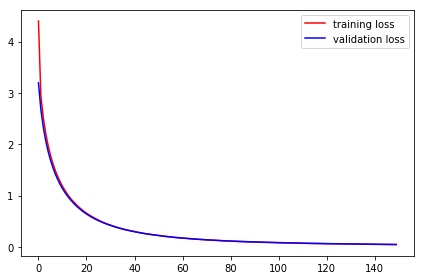

In [16]:

def plot_losses():
    t = np.arange(0, len( history.history['loss']), 1)
    plt.plot(t, history.history['loss'], 'r-', label="training loss")
    plt.plot(t, history.history['val_loss'], 'b-', label="validation loss")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

plot_losses()

We can see a stabilizing loss, but it turns out that the predictions are just not strong enough. If we picture the expected validation angles vs the predicted ones **multiplied by a factor of 6.0** we can see a nice fit:

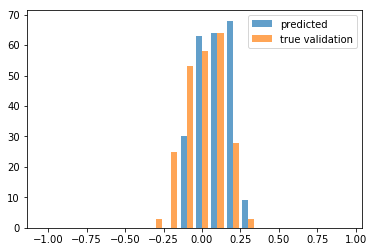

In [19]:
from keras.models import model_from_json
from keras.models import save_model

predicted = []
# load model just like in drive.py and predict validation_data with a factor of 2.5:
with open('model.json', 'r') as jfile:
    model = model_from_json(jfile.read())
    model.compile("adam", "mse")
    weights_file = 'model.h5'
    model.load_weights(weights_file)
    
    save_model(model, 'whole_model')  ## TODO: maybe dump the whole model only to avoid re-saving it here

    factor = 3.0 ## fixed multiplication factor used below
    
    assert(validation_data.shape[0] == len(validation_angles))
    for i in range(0,validation_data.shape[0]):
        predicted = predicted + [float(model.predict(validation_data[i][None, :, :, :], batch_size=1)[0])*factor]

my_bins = np.arange(-1.05, 1.05, 0.1)
data = np.vstack([predicted, validation_angles[:,0]]).T

plt.hist(data, my_bins, alpha=0.7, label=['predicted', 'true validation'])
plt.legend(loc='upper right')
plt.show()


# style transfer from real track during the meetup:


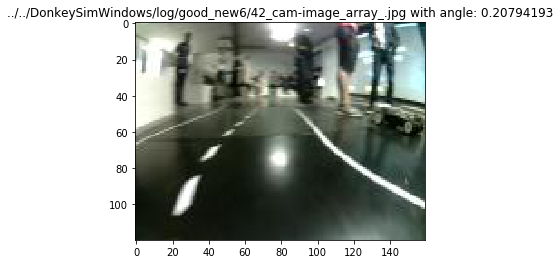

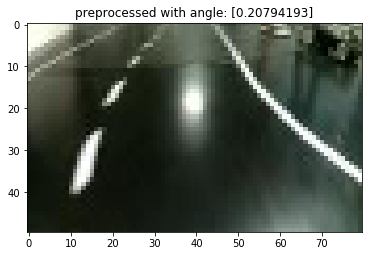

In [26]:
img_idx = 42
file = '../../real-track-recording/tub/27412_cam-image_array_.jpg'

img = cv2.imread(file)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(str(train_json[img_idx][image_pos])+" with angle: " + str(adjusted[img_idx][angle_pos]))
plt.show()


img = preprocess_image(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("preprocessed with angle: " + str(get_all_angles(adjusted)[img_idx]))
plt.show()


In [27]:
cv2.imwrite('style_input.jpg',img)

True

In [28]:
all_processed = get_stacked_data(adjusted)
all_processed.shape

(1167, 50, 80, 3)

In [29]:
all_processed[1].shape

(50, 80, 3)

In [30]:
i = 5
lala = 'processed_'+( '%04d' % i)+'.jpg'
lala

'processed_0005.jpg'

In [31]:
for i in range(len(all_processed)):
    cv2.imwrite('style_training/process_simulator_'+( '%04d' % i)+'.jpg',all_processed[i])
    
# TODO: maybe write those images only and create proper record_.. json object with adjusted angles